In [1]:
from simple_pe.waveforms import calculate_eccentric_harmonics
import numpy as np
from pycbc.filter import overlap_cplx
from pycbc import psd as psd_func

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package o

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [10]:
# Make psd
tlen = 64
f_low = 5
s_rate = 4096
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(s_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = psd_func.analytical.from_string(psds['H1'], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                      psds['f_low'])

# Calculate eccentric harmonics
lms = ['22']
harms = calculate_eccentric_harmonics(
    60, 2, 0.2, 0, 0, 15, 4096, phase=0, inclination=0,
    distance=1, f_ref_e=10, tlen=64, n_ecc_harms=4, n_ecc_gen=6, psd=None,
    orthonormalize=True, align_merger=True
)

In [12]:
# Check overlaps between harmonics
ks = [0, 1, -1, 2]
for i in range(len(ks)):
    for j in range(i+1, len(ks)):
        o = overlap_cplx(harms[ks[i]], harms[ks[j]], psd=psd, low_frequency_cutoff=15)
        print(f'Overlap between k={ks[i]} and k={ks[j]}: {np.abs(o):.5f}')

Overlap between k=0 and k=1: 0.02369
Overlap between k=0 and k=-1: 0.10126
Overlap between k=0 and k=2: 0.00300
Overlap between k=1 and k=-1: 0.01425
Overlap between k=1 and k=2: 0.00017
Overlap between k=-1 and k=2: 0.00598


In [1]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy import integrate
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


We have implicitly assumed so far that the reference frequency of the waveforms was the Keplerian frequency. This is not the case for TEOBResumS, where the reference frequency is defined as the average of the peri- and apastron frequencies. If we are therefore able to convert from the Keplerian frequency ($\omega_\textrm{kep}$) to this TEOBResumS average frequency ($\omega_\textrm{avg}$) we should be able to increase eccentricity while keeping the initial Keplerian frequency constant. This should then give a decreased signal length as we would expect.

Equation 3 in https://arxiv.org/pdf/2207.14346.pdf gives the instantaneous orbital frequency as follows:

$$
\omega (t) = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\cos{E(t)}\right]^2}
$$

The frequency is highest (lowest) at the periastron (apastron). Therefore $\omega_\textrm{peri}$ ($\omega_\textrm{ap}$) corresponds to when $\cos{E(t)} = +1$ ($-1$). Therefore the average frequency used in TEOBResumS is given by:

$$
\omega_\textrm{avg} = \frac{1}{2} \left( \omega_\textrm{peri} + \omega_\textrm{ap} \right) = \frac{1}{2} \left( \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[ 1-e\right]^2} + \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{\left[1+e\right]^2} \right)
$$

$$
\omega_\textrm{avg} = \frac{\omega_\textrm{kep} \sqrt{1-e^2}}{2} \left( \frac{ \left(1+e\right)^2 + \left(1-e\right)^2}{\left(1+e\right)^2 \left(1-e\right)^2} \right)
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right) \sqrt{1-e^2}}{\left(1+e\right)^2 \left(1-e\right)^2}
$$

$$
\omega_\textrm{avg} = \omega_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}~~~~~\textrm{or equivalently}~~~~~f_\textrm{avg} = f_\textrm{kep} \frac{\left(1+e^2\right)}{\left(1-e^2\right)^{3/2}}
$$

Can now write functions converting between $f_\textrm{kep}$ and $f_\textrm{avg}$.

In [2]:
def f_kep2avg(f_kep, e):

    numerator = (1+e**2)
    denominator = (1-e**2)**(3/2)

    return f_kep*(numerator/denominator)

def f_avg2kep(f_avg, e):

    numerator = (1-e**2)**(3/2)
    denominator = (1+e**2)

    return f_avg*(numerator/denominator)

In [3]:
# Converts modes to use into language TEOBResumS understands
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

In [4]:
# Generates TEOBResumS waveform with given parameters
def gen_teob_wf(f_kep, e, M, q, sample_rate, phase):

    f_avg = f_kep2avg(f_kep, e)

    # Define parameters
    k = modes_to_k([[2,2]])
    pars = {
            'M'                  : M,
            'q'                  : q,
            'Lambda1'            : 0.,
            'Lambda2'            : 0.,     
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 0,            # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 0,
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p, teob_c

Now input (and plot) two indentical sets of parameters except one with higher eccentricity

In [ ]:
hp, hc = gen_teob_wf(10, 0.1, 30, 2, 4096, 0)
sp, sc = gen_teob_wf(10, 0.2, 30, 2, 4096, 0)

In [ ]:
plt.plot(hp.sample_times, hp, label='$e_{10} = 0.1$')
plt.plot(sp.sample_times, sp, label='$e_{10} = 0.2$')
plt.legend()

Now higher eccentricity does indeed give lower signal length as we expect due to the faster orbital evolution!

Finally, we should plot waveforms with shifted $f_\textrm{kep}$ using orbital evolution equations to give a shift in true anomaly by 2pi. If our problem has been fixed, the equations should be accurate, and the envelopes of the waveforms should line up.

In [ ]:
from calcwf import shifted_f, shifted_e

In [ ]:
hp, hc = gen_teob_wf(10, 0.1, chirp2total(24, 2), 2, 4096, 0)
s_f = shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_e = shifted_e(s_f, 10, 0.1)
sp, sc = gen_teob_wf(s_f, s_e, chirp2total(24, 2), 2, 4096, 0)

In [ ]:
plt.figure(figsize=(0.65*6.4,0.65*4.8))
plt.plot(sp.sample_times, np.sqrt(sp**2 + sc**2), label='$\psi=2\pi$', alpha=0.7)
plt.plot(hp.sample_times, np.sqrt(hp**2 + hc**2), label='$\psi=0$', alpha=0.7)
plt.plot(sp.sample_times, -np.sqrt(sp**2 + sc**2), c='C0', alpha=0.7)
plt.plot(hp.sample_times, -np.sqrt(hp**2 + hc**2), c='C1', alpha=0.7)
plt.plot(sp.sample_times, sp, c='C0')
plt.plot(hp.sample_times, hp, c='C1')
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-6.8, -6.1)
plt.ylim(-1.5e-19, 1.6e-19)
plt.tight_layout()
plt.savefig('Figures/2piTA.pdf')

Success!

# Shifting phase

We should also be able to shift the phase to be in line analytically as well. Any waveform (with the default phase value) starts with $\psi_0 = \Omega_0 = 0$, where $\psi_0$ and $\Omega_0$ describe the initial phase and argument of apoapsis respectively. For a waveform shifted back by $2\pi$ in mean anomaly, when it reaches the start of the original waveform after completing one amplitude modulation it has $\psi = \Omega = \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$.

Therefore all we need to do to generate make the second waveform in phase with the original is to generate it with an initial phase of $\psi_0 = \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$.

In [5]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096

In [6]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f = shifted_f(f_low, e, chirp2total(chirp, q), q)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift
P = P_from_f(f_low)
s_phase = -peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

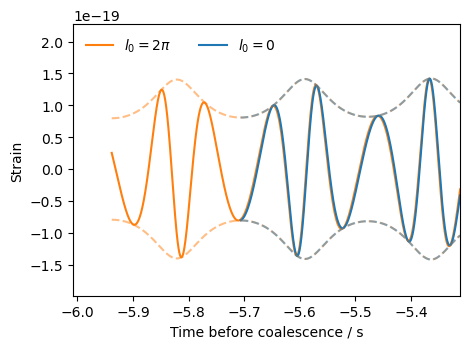

In [7]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='$l_0=2\pi$')
plt.plot(h.sample_times, h.real(), c='C0', label='$l_0=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = h.sample_times[0]-s.sample_times[0]
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+1.7*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

The more general case is a little trickier. We will still start at apoapsis with $\psi_0 = \Omega_0 = 0$ by default, however will now join the original waveform at $\Omega = \frac{M}{2\pi} \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1}$, with $M$ being the mean anomaly we are shifting by. At this point, the phase has evolved to $\psi = \Omega + T$ where $T$ is the true anomaly corresponding to the mean anomaly $M$. We must therefore simply generate the second waveform with a phase of $\psi_0 = \frac{M}{2\pi} \Delta \phi \left(1 - \frac{\Delta \phi}{2\pi}\right)^{-1} - T$.

$T$ is defined in terms of $M$ only as an infinite series. In order to not be dependent on too many other packages, will write simple implementation myself here. First off will need to find eccentric anomaly from mean anomaly with a root solving algorithm (scipy minimize), and can then convert analytically to true anomaly.

In [2]:
def EA2MA(EA, e):
    MA = EA - e*np.sin(EA)
    return MA

def MA2EA(MA, e):
    bounds = [(0, 2*np.pi)]
    init_guess = MA
    best_fit = minimize(lambda x: np.abs(MA - EA2MA(x, e)), init_guess, bounds=bounds)
    EA = best_fit['x'][0]
    return EA

def EA2TA(EA, e):
    arg_num = np.sqrt(1+e)*np.sin(EA/2)
    arg_denom = np.sqrt(1-e)*np.cos(EA/2)
    TA = 2*np.arctan2(arg_num, arg_denom)
    return TA

def TA2EA(TA, e):
    arg_num = np.sqrt(1-e**2)*np.sin(TA)
    arg_denom = e+np.cos(TA)
    EA = np.arctan2(arg_num, arg_denom)
    EA = EA%(2*np.pi)
    return EA

def MA2TA(MA, e):
    TA = EA2TA(MA2EA(MA, e), e)
    return TA

def TA2MA(TA, e):
    MA = EA2MA(TA2EA(TA, e), e)
    return MA

In [10]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096
MA_shift = 1.735243

In [11]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
s_f = f_low - MA_shift*s_f_2pi/(2*np.pi)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift
P = P_from_f(f_low)
T = MA2TA(MA_shift, e)
s_phase = -MA_shift*peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)/(2*np.pi) - T

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

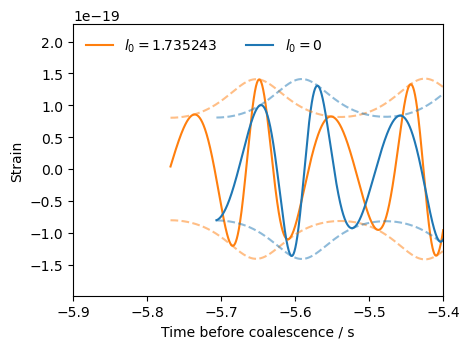

In [12]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label=f'$l_0={MA_shift}$')
plt.plot(h.sample_times, h.real(), c='C0', label='$l_0=0$')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-5.9, -5.4)
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

It is hard to visually tell for arbitrary mean anomaly shifts how accurate this is. Instead, let's compare the numerical phase shift we calculated to our previous method of finding the phase of the waveforms with default phase values.

In [ ]:
# Parameters
f_low = 10
e = 0.5
chirp = 24
q = 2
sample_rate = 4096
MA_shift = 0.463542

In [ ]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
s_f = f_low - MA_shift*s_f_2pi/(2*np.pi)
s_e = shifted_e(s_f, f_low, e)

# Calculate phase shift analytically
P = P_from_f(f_low)
T = (true_anomaly_from_mean(e, MA_shift+np.pi)-np.pi)%(2*np.pi)
s_phase = -MA_shift*peri_advance_orbit(P, e, total_mass_kg)*num_orbits(P, e, total_mass_kg)/(2*np.pi) - MA_shift
print(f'True anomaly: {T}')
print(f'Analytic phase shift: {s_phase}')
a = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=s_phase)

# Calculate phase shift by generating waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')
overlap = overlap_cplx_wfs(s, h, f_low)
phase_angle = np.angle(overlap)/2
print(f'Extra waveform generation phase shift: {phase_angle}')
b = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=phase_angle)

print(f'Difference: {phase_angle-s_phase}')

In [ ]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.plot(h.sample_times, h.real(), c='C0', label='original')
plt.plot(b.sample_times, b.real(), c='C1', label='wf generation')
plt.plot(a.sample_times, a.real(), c='C2', label='analytic')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, np.abs(b), c='C1', ls='dashed', alpha=0.5)
plt.plot(a.sample_times, np.abs(a), c='C2', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, -np.abs(b), c='C1', ls='dashed', alpha=0.5)
plt.plot(a.sample_times, -np.abs(a), c='C2', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
plt.xlim(-2, -1.5)
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

It seems like using mean anomaly is actually correct instead of true anomaly, which is a surprise to me. Will have to think about why this is.

# TEOBResumS-Dali

Using the Dali branch of teobresums instead of the 'eccentric' branch (outdated, no longer supported), we now have the options to specify both an orbit averaged frequency, and the initial anomaly of the waveform. In this section we will check that these are equivalent to the approaches above.

In [5]:
# Generates TEOBResumS waveform with given parameters
def test_teob_wf(input_f, e, M, q, sample_rate, phase, ecc_freq, MA=np.pi, built_in_anom=False):

    # Handle frequency definitions
    if ecc_freq == 'average':
        f_avg = f_kep2avg(input_f, e)
        ecc_freq_id = 1
    elif ecc_freq == 'orbitaveraged':
        f_avg = input_f
        ecc_freq_id = 3

    # Handle different mean anomalies
    if built_in_anom:
        TA = TA2MA(MA, e)
    else:
        MA_shift = (MA + np.pi)%(2*np.pi)
        s_f_2pi = f_avg - shifted_f(f_avg, e, M, q)
        s_f = f_avg - MA_shift*s_f_2pi/(2*np.pi)
        s_e = shifted_e(s_f, f_avg, e)
        f_avg, e, = s_f, s_e
        TA = np.pi        

    # Define parameters
    k = modes_to_k([[2,2]])
    pars = {
            'M'                  : M,
            'q'                  : q, 
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 'no',         # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 'no',         # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_avg,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 'yes',        # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'coalescence_angle'  : phase,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 'no',
            'ecc_freq'           : ecc_freq_id,
            'anomaly'            : TA
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p - 1j*teob_c

First let's compare specifying an orbit average frequency to the conversion function we have written.

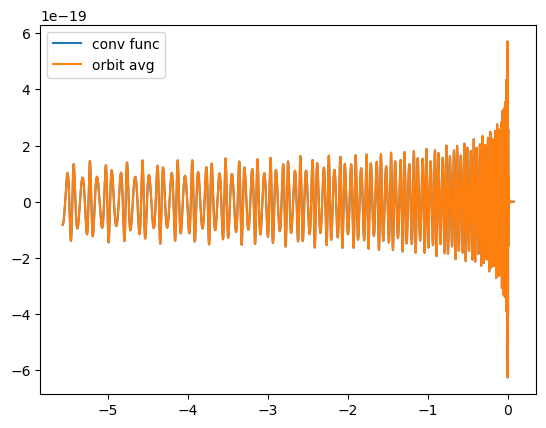

In [10]:
# Generate waveforms
conv = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'average')
orbavg = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged')

# Make comparison plot
plt.plot(conv.sample_times, conv, label='conv func')
plt.plot(orbavg.sample_times, orbavg, label='orbit avg')
plt.legend()

This indeed seems to be equivalent.

Now we should check that the new anomaly parameter is indeed true anomaly, once again by comparing against our solution/workaround.

5.5 5.16421216825916


(-2e-19, 2e-19)

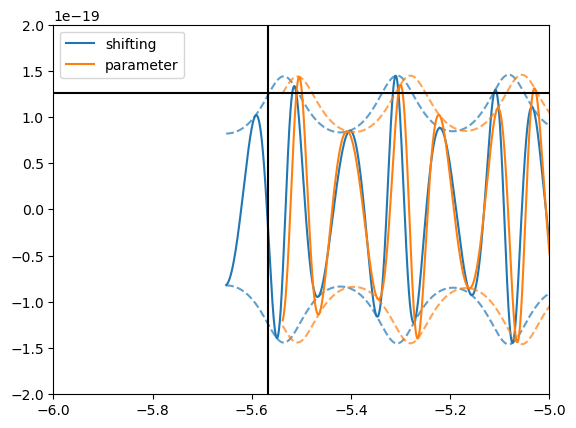

In [11]:
# Generate waveforms
base = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=np.pi, built_in_anom=False)
base_time = base.sample_times[0]
shifting = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=5.5, built_in_anom=False)
param = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=5.5, built_in_anom=True)

# Make comparison plot
plt.plot(shifting.sample_times, shifting, c='C0', label='shifting')
plt.plot(shifting.sample_times, np.abs(shifting), c='C0', ls='dashed', alpha=0.7)
plt.plot(shifting.sample_times, -np.abs(shifting), c='C0', ls='dashed', alpha=0.7)
plt.plot(param.sample_times, param, c='C1', label='parameter')
plt.plot(param.sample_times, np.abs(param), c='C1', ls='dashed', alpha=0.7)
plt.plot(param.sample_times, -np.abs(param), c='C1', ls='dashed', alpha=0.7)
plt.axvline(base_time, c='k')
plt.axhline(np.abs(param[0]), c='k')
plt.legend()
plt.xlim(-6,-5)
plt.ylim(-2e-19, 2e-19)

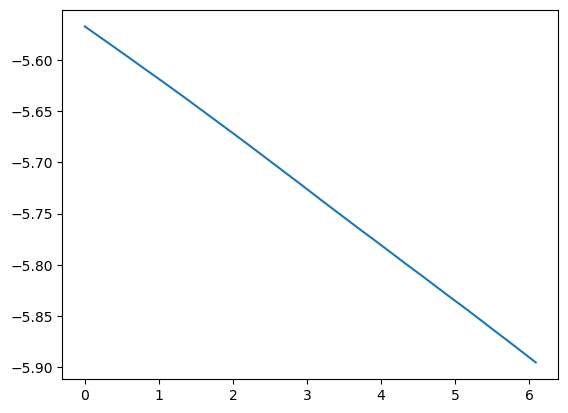

In [12]:
times = []
for i in range(32):
    h = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'average', MA=i*2*np.pi/32+np.pi, built_in_anom=False)
    times.append(h.sample_times[0])
plt.plot(np.linspace(0,2*np.pi, 32, endpoint=False), times)

0.0 0.0
1.5707963267948966 1.1734792265819114
3.141592653589793 3.141592653589793
4.71238898038469 5.109706080597675


(-2e-19, 2e-19)

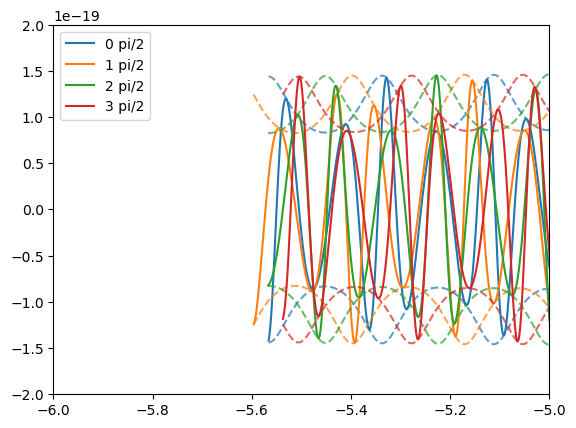

In [16]:
for i in range(4):
    h = test_teob_wf(10, 0.2, 60, 2, 4096, 0, 'orbitaveraged', MA=i*np.pi/2, built_in_anom=True)
    plt.plot(h.sample_times, h, c=f'C{i}', label=f'{i} pi/2')
    plt.plot(h.sample_times, abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
    plt.plot(h.sample_times, -abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
plt.legend()
plt.xlim(-6,-5)
plt.ylim(-2e-19, 2e-19)

# Predicting the time shift

0.0 0.0
0.1285299488607818 0.19634953975268962


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.25871595831060445 0.39269907565269
0.39224458840808263 0.5890486187274205
0.5308593165554508 0.7853981575726569
0.6763778208093767 0.9817476985766805
0.8306931800176043 1.1780972406582313
0.9957494321823235 1.3744467827896611
1.1734792265819114 1.5707963250116068
1.3656898926576317 1.767145865360427
1.5738866264973483 1.9634954079246634
1.7990311593875243 2.1598449482389093
2.0412543939062435 2.356194488224897
2.2995716729898263 2.5525440277848848
2.571681115131238 2.7488935689252743
2.853940290409628 2.9452431110600394
3.141592653589793 3.141592653589793
3.429245016769958 3.337942191457529
3.711504192048347 3.5342917338217825
3.98361363418976 3.730641274952225
4.241930913273342 3.926990812605826
4.4841541477920615 4.123340353300526
4.709298680682237 4.319689895790937
4.917495414521954 4.516039437491271
5.109706080597675 4.712388977724338
5.2874358749972625 4.908738518480978
5.452492127161983 5.105088056589737
5.606807486370209 5.3014375974506995
5.752325990624135 5.497787138351886
5

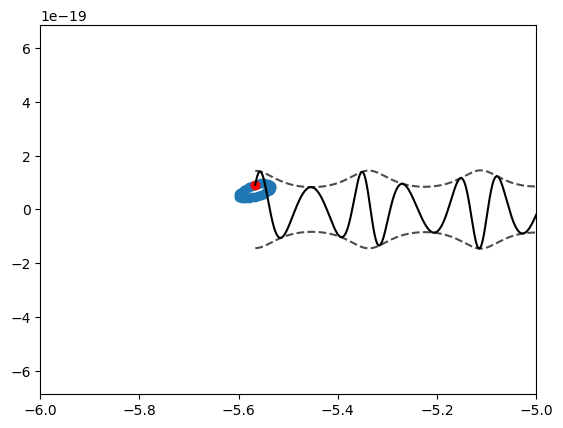

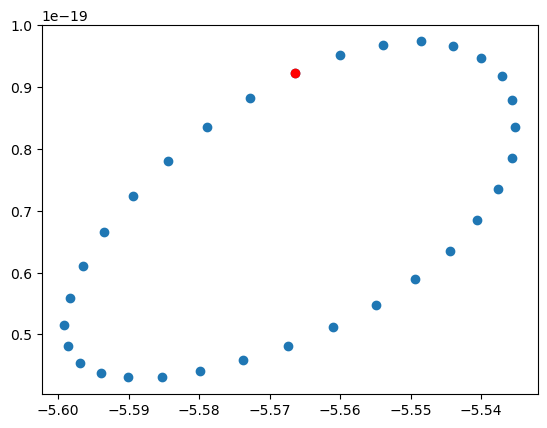

In [15]:
start_times = []
start_strain = []
for i in range(32):
    h = test_teob_wf(10, 0.2, 60, 2, 4096, np.pi/3, 'orbitaveraged', MA=TA2MA(i*np.pi/16, 0.2), built_in_anom=True)
    if i == 0:
        plt.plot(h.sample_times, h, c='k')
        plt.plot(h.sample_times, np.abs(h), c='k', ls='dashed', alpha=0.7)
        plt.plot(h.sample_times, -np.abs(h), c='k', ls='dashed', alpha=0.7)
    start_times.append(h.sample_times[0])
    start_strain.append(np.real(h[0]))
plt.scatter(start_times, start_strain)
plt.scatter(start_times[0], start_strain[0], c='r')
plt.xlim(-6, -5)
plt.show()

plt.scatter(start_times, start_strain)
plt.scatter(start_times[0], start_strain[0], c='r')
plt.show()

In [17]:
def power_radiated(TA, f, e, M, q):

    # Calculate mass quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M

    # Calculate semi major axis
    a = a_from_P(P_from_f(f), M)

    # Calculate power radiated
    prefactors = (8*const.G**4*mu**2*M**3)/(15*const.c**5*a**5*(1-e**2)**5)
    TA_factors = (1+e*np.cos(TA))**4*(12*(1+e*np.cos(TA))**2+e**2*np.sin(TA)**2)

    return prefactors*TA_factors

def total_E(f, M, q):

    # Calculate mass quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M

    # Calculate semi major axis
    a = a_from_P(P_from_f(f), M)

    # Calculate total energy of system
    E = (const.G*M*mu)/(2*a)

    return E

(0.0, 6.283185307179586)

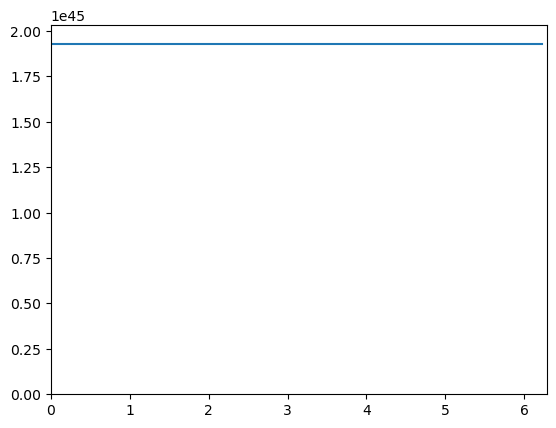

In [18]:
power = []
for i in range(100):
    power.append(power_radiated(i*np.pi/50, 10, 0, 60, 2))
plt.plot(np.linspace(0, 2*np.pi, 100, endpoint=False), power)
plt.ylim(0,)
plt.xlim(0, 2*np.pi)

In [19]:
def power_integrand(TA, f, e, M, q):

    # Calculate mass quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M

    # Calculate semi major axis, angular momentum, and radius
    a = a_from_P(P_from_f(f), M)
    L = np.sqrt(const.G*M*mu**2*a*(1-e**2))
    r = a*(1-e**2)/(1+e*np.cos(TA))

    # Calculate rate of change of true anomaly
    mass_factor = 2*const.G*M/(a*const.c**2*(1-e**2))
    aps_derivative = np.sqrt(1-mass_factor*(3+e*np.cos(TA)))
    TA_rate = aps_derivative*L/(mu*r**2)

    # Calculate integrand of power integral
    power_instantaneous = power_radiated(TA, f, e, M/aconst.M_sun.value, q)
    integrand = power_instantaneous/TA_rate

    return integrand

def aps_advance_integrand(TA, f, e, M):

    # Calculate mass quantities
    M *= aconst.M_sun.value

    # Calculate semi major axis
    a = a_from_P(P_from_f(f), M)

    # Calculate integrand of integral
    mass_factor = 2*const.G*M/(a*const.c**2*(1-e**2))
    integrand = 1/np.sqrt(1-mass_factor*(3+e*np.cos(TA)))

    return integrand

def freq_shift_to_peri(TA, f, e, M, q):

    # Calculate constants before integral
    prefactor = 3*f/(2*total_E(f, M, q))

    # Calculate power integral
    power_integral = integrate.quad(power_integrand, TA, 2*np.pi, args=(f, e, M, q))

    return prefactor*power_integral[0]

In [20]:
print(freq_shift_to_peri(0, 10, 0.2, 60, 2))
print(10-shifted_f(10, 0.2, 60, 2))

0.16810293943871696
0.16514079263048131


In [21]:
# Used to help sense check results of above functions
def total_energy_radiated(f, e, M, q):

    # Calculate mass quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M

    # Calculate semi major axis
    a = a_from_P(P_from_f(f), M)

    # Calculate average power radiated
    prefactors = (32*const.G**4*mu**2*M**3)/(5*const.c**5*a**5)
    ecc_factor = (1+73*e**2/24+37*e**4/96)*(1-e**2)**(-7/2)
    avg_power = prefactors*ecc_factor

    return avg_power*(2/f)

In [22]:
def time_shift_to_peri(TA, f, e, M, q):

    # Calculate corresponding freq shift, mean anomaly, and time period
    f_shift = freq_shift_to_peri(TA, f, e, M, q)
    f_shift_2pi = freq_shift_to_peri(0, f, e, M, q)
    MA = TA2MA(TA, e)
    T = 2/f

    # Calculate predicted time shift
    t_shift = T*(f_shift/f_shift_2pi - (2*np.pi - MA)/(2*np.pi))
    
    return t_shift

Now compare this to the actual time shifts computed above.

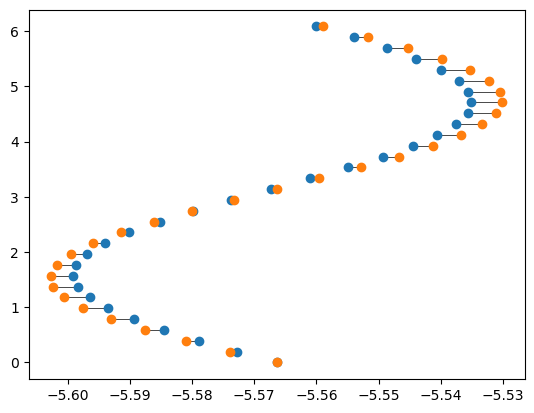

In [23]:
predict_ts = []
for i in range(32):
    TA = i*np.pi/16
    predict_t_shift = time_shift_to_peri(TA, 10, 0.2, 60, 2)
    predict_ts.append(start_times[0] + predict_t_shift)
plt.scatter(start_times, np.linspace(0, 2*np.pi, 32, endpoint=False))
plt.scatter(predict_ts, np.linspace(0, 2*np.pi, 32, endpoint=False))
plt.hlines(y=np.linspace(0, 2*np.pi, 32, endpoint=False), xmin=np.min([predict_ts, start_times], axis=0), xmax=np.max([predict_ts, start_times], axis=0), colors='k', lw=0.5, zorder=0)

This is pretty close but not quite fully correct - we seem to be predicting greater deviations from constant evolution over orbits than actually seems to occur.

For now let's continue and try to apply these results to convert from our equal spacing to the equivalent spacing in true anomaly. Turning the above equations around to make true anomaly the subject is certainly unlikely to be feasible, and so we will use scipy.optimize.minimize.

In [24]:
# For now referring to equally spaced angle as apsidal anomaly (AA) in code
def TA2AA(TA, f, e, M, q):

    # Calculate conversion to apsidal angle
    f_shift = freq_shift_to_peri(TA, f, e, M, q)
    f_shift_2pi = freq_shift_to_peri(0, f, e, M, q)
    adjustment = 2*np.pi-TA2MA(TA, e) - 2*np.pi*f_shift/f_shift_2pi
    AA = MAT2A2*np.pi*(1 - f_shift/f_shift_2pi) 

    return AA

def AA2TA(AA, f, e, M, q):
    bounds = [(0, 2*np.pi*0.9999999)]
    init_guess = AA
    best_fit = minimize(lambda x: np.abs(AA - TA2AA(x, f, e, M, q)), init_guess, bounds=bounds)
    TA = best_fit['x'][0]
    return TA

0.0 0.0
0.6320593417195033 0.9230742071331074
3.141592653589793 3.141592653589793
5.651125961064346 5.360111086852152


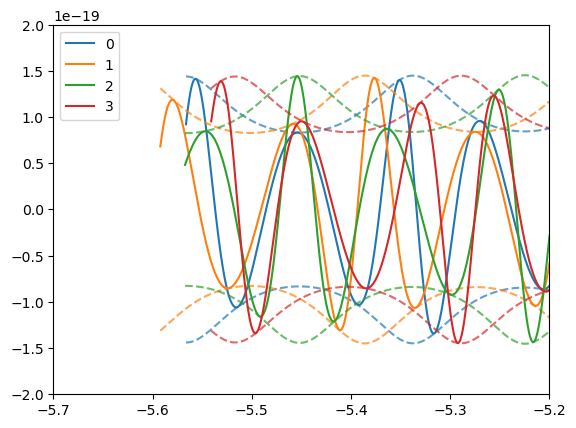

In [25]:
for i in range(4):
    TA = AA2TA(i*np.pi/2, 10, 0.2, 60, 2)
    h = test_teob_wf(10, 0.2, 60, 2, 4096, np.pi/3, 'orbitaveraged', MA=TA2MA(TA, 0.2), built_in_anom=True)
    plt.plot(h.sample_times, h, c=f'C{i}', label=str(i))
    plt.plot(h.sample_times, np.abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
    plt.plot(h.sample_times, -np.abs(h), c=f'C{i}', ls='dashed', alpha=0.7)
plt.xlim(-5.7, -5.2)
plt.ylim(-2e-19, 2e-19)
plt.legend()

This is close but not quite accurate (certainly not accurate enough for our purposes). More work therefore needs to be done here to improve the accuracy of this conversion.

# Theory

Here I am typing up the theory underpinning the functions above.

The reason that our equal spacing in apsidal epoch times (henceforth known as apsidal anomaly (AA)) cannot be directly translated into true anomaly (TA) is because it differs from mean anomaly (MA) in that varying MA/TA varies the length of the waveform, and hence the start time (see above plots). If we can predict this shift of the start time from the initial TA then we should be able to convert between AA and standard anomalies.

The non-trivial part here is that we want to examine incomplete parts of orbits, whereas the majority of equations simply take averages over full orbits for simplicity as this bypasses the issue of parameters evolving at varying rates at different points in the orbit. We will need to take this into account as it is responsible for the time shifts we want to be able to model.

Maggiore gives the power radiated at a given TA as (also given as derivation of total radiated power in Peters and Mathews 1963)

$$
P(\psi) = \frac{8G^4}{15c^5} \frac{\mu^2M^3}{a^5\left(1-e^2\right)^5} \left(1+e\cos{\psi}\right)^2 \left[12\left(1+e\cos{\psi}\right)^2 + e^2\sin{\psi}^2\right],
$$

where $\mu$ is the reduced mass and $\psi$ refers to TA.

We want to be able to relate this power radiated to an increase in frequency which we can achieve by combining Kepler's 3rd law

$$
GM = \left(\frac{2\pi}{T}\right)^2 a^3,
$$

$$
a = \sqrt[3]{GM\left(\frac{T}{2\pi}\right)^2},
$$

with the equation for orbital energy

$$
E = - \frac{GM\mu}{2a},
$$

as

$$
E = - \frac{\mu}{2} \left(\frac{2\pi GM}{T}\right)^{2/3}.
$$

Taking the time derivative we find

$$
\dot{E} = \frac{\mu}{2} \left(\frac{2\pi GM}{T}\right)^{2/3} \frac{2\dot{T}}{3T},
$$

$$
\frac{\dot{T}}{T} = \frac{3}{2}\frac{\dot{E}}{E}.
$$

We finally use $P = - \dot{E}$ and $T = 2/f$ to find

$$
\frac{\dot{f}}{f} = \frac{3}{2}\frac{P(\psi)}{E}.
$$

We now integrate to find the change in frequency by the time the system has evolved from an arbitrary starting TA to periapsis ($\psi=2\pi$).

$$
\Delta f (\psi) = \frac{3f}{2E} \int_\psi^{2\pi} \frac{P(\psi)}{\dot{\psi}}d\psi.
$$

This requires us to know $\dot{\psi}$, the rate of change of TA with time. We can start from a well known result for the orbital phase:

$$
\dot{\phi} = \frac{|L|}{\mu r^2},
$$

where 

$$
r = \frac{a\left(1-e^2\right)}{1+e\cos{\psi}},
$$

and $|L|$ is the orbital angular momentum given by

$$
|L| = \sqrt{GM\mu^2 \left(1-e^2\right)},
$$

giving

$$
\dot{\phi} = \left(1+e\cos{\psi}\right)^2 \sqrt{\frac{GM}{a^3\left(1-e^2\right)^3}}.
$$

We can now find $\dot{\psi}$ as

$$
\dot{\psi} = \frac{d\psi}{d\phi} \dot{\phi},
$$

with this derivative given by equation 13 of https://www.mathpages.com/rr/s6-02/6-02.htm as

$$
\frac{d\psi}{d\phi} = \sqrt{1-\frac{2GM}{ac^2\left(1-e^2\right)}\left(3+e\cos{\psi}\right)}
$$

We can now work out the additional angular offset introduced by these shifting start times by comparing the frequency shift computed above to the expectation if the frequency evolution were constant over the orbit (i.e. parameterised linearly with MA). 

$$
\left(2\pi - \mathrm{MA}\right) - \frac{\Delta f(\psi)}{\Delta f(0)} 2\pi
$$

Multiplying this by $T/2\pi$ gives the time offset that must be subtracted from the start time of a waveform at $\psi=0$ to find the predicted start time of a waveform at an arbitrary TA of $\psi$.

In order to convert from standard anomalies to AA, we therefore only need to take this into account, and we find that

$$
AA = MA + \left(2\pi - MA\right) - \frac{\Delta f(\psi)}{\Delta f(0)} 2\pi,
$$

$$
AA = - \frac{\Delta f(\psi)}{\Delta f(0)} 2\pi,
$$

In reality we need to convert the other way, from equal spacing in AA to the equivalent in TA, which we achieve through numerical methods.

# Shifting phase revisited

In [11]:
# Parameters
f_low = 10
e = 0.2
chirp = 24
q = 2
sample_rate = 4096
MA_shift = np.sqrt(2)

In [12]:
total_mass_kg = chirp2total(chirp, q)*aconst.M_sun.value

# Create original waveform
h = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate shifts in frequency and eccentricity
s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
s_f = f_low - MA_shift*s_f_2pi/(2*np.pi)
s_e = shifted_e(s_f, f_low, e)

# Create shifted waveform
s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS')

# Calculate phase shift
overlap = overlap_cplx_wfs(h, s, f_low)
phase_angle = np.angle(overlap)

# Correct phase of shifted waveform
s *= np.exp(1j*phase_angle)

# Generating new waveform with calculated phase for comparison
b = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, 'TEOBResumS', phase=-phase_angle/2)

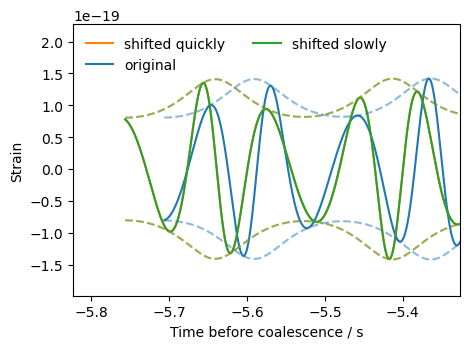

In [13]:
# Make plot, shifting arbitrary amount in mean anomaly
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.plot(s.sample_times, s.real(), c='C1', label='shifted quickly')
plt.plot(h.sample_times, h.real(), c='C0', label='original')
plt.plot(b.sample_times, b.real(), c='C2', label='shifted slowly')
plt.plot(s.sample_times, np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, np.abs(b), c='C2', ls='dashed', alpha=0.5)
plt.plot(s.sample_times, -np.abs(s), c='C1', ls='dashed', alpha=0.5)
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed', alpha=0.5)
plt.plot(b.sample_times, -np.abs(b), c='C2', ls='dashed', alpha=0.5)
plt.legend(loc='upper left', frameon=False, ncol=2)
plt.xlabel('Time before coalescence / s')
plt.ylabel('Strain')
len_2pi = (h.sample_times[0]-s.sample_times[0])*2*np.pi/MA_shift
plt.xlim(s.sample_times[0]-0.3*len_2pi, h.sample_times[0]+1.7*len_2pi)
max_h = max(np.abs(h[:int(1.7*len_2pi*sample_rate)]))
plt.ylim(-1.4*max_h, 1.6*max_h)
plt.tight_layout()

In [14]:
overlap = overlap_cplx_wfs(b, s, f_low)
phase_angle = np.angle(overlap)

print(phase_angle/2)

-2.2750855121408705e-16


The below is a more complicated method I was developing before the far simpler solution above, which I am keeping here for posterity's sake.

As we are unlikely to use the true anomaly parameter in teobresumsdali just yet, it would still be nice to be able to shift the phase using our old methods of shifting frequency and eccentricity. Let's revisit this then with our improved understanding from recent work above.

We would like to be able to track the evolution of orbital phase between the start of the shifted waveform and the start of the origianl waveform. We can calculate the time difference here and so should be able to use the equation we have above for the rate of change of orbital phase w.r.t. time. One slight complication is that this depends on true anomaly and so we must also keep track of this. In theory we may be able to use the result of the above to get a value for the TA (numerically) however we know that this is not very accurate right now. 

Instead I will try to evolve the TA using Euler's method along the required time using the equation for $\dot{\psi}$ above.

The time between the start of the waveform and the original start for a waveform shfited back $2\pi$ (in any anomaly) is given by

$$
\Delta t_\mathrm{start} = n_\mathrm{orbits} T = \frac{2}{f} \left(1 - \frac{\Delta \Omega}{2\pi}\right)^{-1},
$$

where

$$
\Delta \Omega = \frac{6\pi G}{c^2}\frac{m_1+m_2}{a\left(1-e^2\right)}.
$$

The time for a generic waveform shifted back by AA is therefore

$$
\Delta t_\mathrm{start} = \frac{\mathrm{AA}}{\pi f} \left(1 - \frac{\Delta \Omega}{2\pi}\right)^{-1}.
$$

The change in orbital phase is therefore computed as 

$$
\Delta \phi = \sqrt{\frac{GM}{a^3\left(1-e^2\right)^3}} \int_{t_\mathrm{start}}^{t_\mathrm{start}+\Delta t_\mathrm{start}} \left(1+e\cos{\psi}\right)^2 dt.
$$

We know how $\psi$ evolves from the equation for $\dot{\psi}$ above. We also know that the initial condition that $\psi = 0$ at $t=t_\mathrm{start}$, so should be able to track the evolution of orbital phase (at least over short periods of time where $a$ and $e$ can be treated to be roughly constant).

In [91]:
# Calculate instantaneous rate of change of TA w.r.t. time
def TA_roc(TA, f, e, M, q):

    # Calculate mass quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M

    # Calculate semi major axis, angular momentum, and radius
    a = a_from_P(P_from_f(f), M)
    L = np.sqrt(const.G*M*mu**2*a*(1-e**2))
    r = a*(1-e**2)/(1+e*np.cos(TA))

    # Calculate rate of change of true anomaly
    mass_factor = 2*const.G*M/(a*const.c**2*(1-e**2))
    aps_derivative = np.sqrt(1-mass_factor*(3+e*np.cos(TA)))
    TA_rate = aps_derivative*L/(mu*r**2)

    return TA_rate

def evolve_TA(TA_0, f, e, M, q, delta_t, n):

    # Setup
    dt = delta_t/n
    TAs = np.zeros(n+1)
    TAs[0] = TA_0
    times = np.linspace(0, delta_t, n+1)

    # Evolve
    for i in range(n):
        TA_rate = TA_roc(TAs[i], f, e, M, q)
        TAs[i+1] = TAs[i] + TA_rate*dt

    return times, TAs

def TA_interp_obj(TA_0, f, e, M, q, delta_t, n=100):
    times, TAs = evolve_TA(TA_0, f, e, M, q, delta_t, n)
    interp_obj = interp1d(times, TAs)
    return interp_obj

In [92]:
def phase_change_integrand(t, e, interp_obj):
    return (1+e*np.cos(interp_obj(t)))**2

def phase_change(f, e, M, q, delta_t, interp_obj=None, TA_0=0, n=1000):

    # Calculate TAs if not passed
    if interp_obj is None:
        interp_obj = TA_interp_obj(TA_0, f, e, M, q, delta_t, n=n)

    # Calculate physical quantities
    M *= aconst.M_sun.value
    m2 = M/(1+q)
    m1 = M - m2
    mu = m1*m2/M
    a = a_from_P(P_from_f(f), M)

    # Calculate change in phase
    prefactors = np.sqrt(const.G*M/(a**3*(1-e**2)**3))
    integral = integrate.quad(phase_change_integrand, 0, delta_t, args=(e, interp_obj))

    return prefactors*integral[0]

In reality we do not want to exactly match the phase of the original waveform at its start time. As the phase evolution depends on TA, the phases would go out of sync again. Instead we want to match some kind of 'TA-averaged' phase. It is not immediately obvious to me how one might calculate this so will calculate the (orbital) phase evolution for a range of initial TAs. First off will do so with all starting with the same phase of zero.

/tmp/ipykernel_1512583/289207141.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = integrate.quad(phase_change_integrand, 0, delta_t, args=(e, interp_obj))
/tmp/ipykernel_1512583/289207141.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = integrate.quad(phase_change_integrand, 0, delta_t, args=(e, interp_obj))


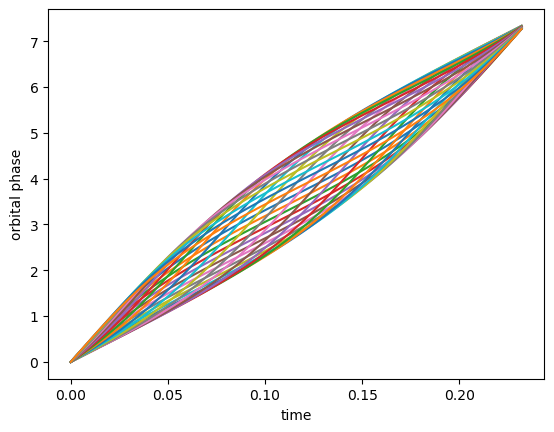

Text(0, 0.5, 'normalised orbital phase')

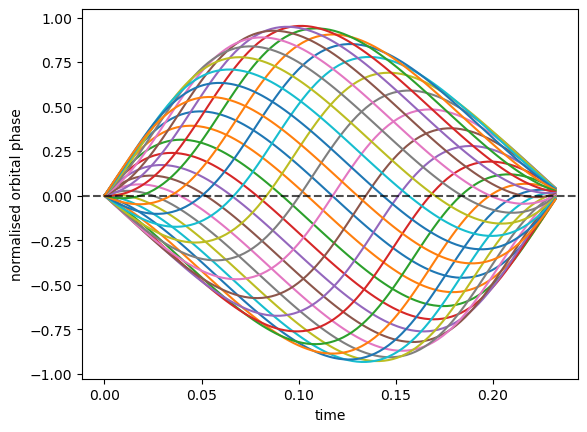

In [111]:
# Parameters
f = 10
e = 0.2
M = 60
q = 2

# Calculate evolutions
delta_t = (2/f)*num_orbits(P_from_f(f), e, M*aconst.M_sun.value)
orbital_phases = []
delta_orbital_phases = []
for TA_0 in np.linspace(0, 2*np.pi, 32, endpoint=False):
    interp_obj = TA_interp_obj(TA_0, f, e, M, q, delta_t, n=100)
    orbital_phases.append([])
    delta_orbital_phases.append([])
    for t in np.linspace(0, delta_t, 101):
        orbital_phases[-1].append(phase_change(f, e, M, q, t, interp_obj=interp_obj))
        delta_orbital_phases[-1].append(orbital_phases[-1][-1] - np.pi*f*t)

# Plot orbital phase with time
for i in range(len(orbital_phases)):
    plt.plot(np.linspace(0, delta_t, 101), orbital_phases[i], label='TA = {:.2f}'.format(i*np.pi/4))
plt.xlabel('time')
plt.ylabel('orbital phase')
#plt.legend()
plt.show()

# Plot difference between actual orbital phase and constant rate orbital phase with time
for i in range(len(delta_orbital_phases)):
    plt.plot(np.linspace(0, delta_t, 101), delta_orbital_phases[i], label='TA = {:.2f}'.format(i*np.pi/4))
plt.axhline(0, c='k', ls='dashed', alpha=0.7)
plt.xlabel('time')
plt.ylabel('normalised orbital phase')
#plt.legend()

This clearly shows how waveforms at the same phase at the same time but with differing TAs will quickly go out of sync (and by a significant margin). The initial phase does not matter for the shape of the 'evolution pattern' above, which is purely determined by the initial TA, and will simply shift the pattern up or down.

The simplest approach is to choose the initial phase to be such that half of the pattern is above and half below the 'normalisation line'. Whether this should be half in terms of area or time is less clear, however as all the patterns appear to be sinusoidal the simplest and easiest implementation that I can see is to calculate the maximum and minimum value of the 'normalised orbital phase' and adjust accordingly.

We could achieve this by first working out the times that the maximum and minimum times are reached numerically (but without integration) and then only evaluating the phase shift integral once, which would be slightly faster. Likely to be simpler and more accurate however is to just numerically optimise the result of the phase shift integral directly, which should still be fast enough to have a negligible affect on performance.